In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import pylab as pl
import math

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (15,15)


In [4]:
# read data
all_data = pd.read_csv("blood_test.txt")

# set labale addicted to data
def SetLabel(row):
    if row['drinks'] > 5 :
        return 1
    return 0

all_data['addicted'] = all_data.apply (lambda row: SetLabel(row), axis=1)

# seperate test and train data
train_data = all_data.loc[all_data['selector'] == 1]
train_data = train_data.drop('selector', axis=1)

test_data = all_data.loc[all_data['selector'] == 2]
test_data = test_data.drop('selector', axis=1)

# shffule data 
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

# Prior prob of each class 
P0 = train_data.loc[train_data['addicted'] == 0].shape[0] / train_data.shape[0]
P1 = train_data.loc[train_data['addicted'] == 1].shape[0] / train_data.shape[0]

test_data_labels = test_data["addicted"]
test_data = test_data.drop('addicted', axis=1)

In [5]:
#pdf of the multivariate normal distribution
def NormalMultivariate(x, d, mean, covariance):
    x_m = x - mean
    seg_1 = np.sqrt((2 * np.pi)**(d/2) * np.linalg.det(covariance))
    return ((1. / seg_1) * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))


In [6]:

PlotIndex = 1

# Function to evalaute test data based on given prior and cost values 
# and normal distribution of each class 
def Evaluate(test_data,addicted_mean,addicted_covariance,not_addicted_mean,not_addicted_covariance,count,P0=0.5,P1=0.5,l12=1,l21=1):
    global PlotIndex
    Equal = 0
    #Confusion Matrix array
    CM = np.full((2,2),0, dtype = np.uint8)
    
    # select each test data
    for test in range(0,len(test_data)) :
        x = np.array(test_data.loc[test])
        y = test_data_labels.loc[test]

        # pmf of normal distribution of each class
        p1= NormalMultivariate(x,len(x),addicted_mean,addicted_covariance)
        p0= NormalMultivariate(x,len(x),not_addicted_mean,not_addicted_covariance)
        
        y_predict = 0
        
        # prediction rule 
        if p1*l21*P1 > p0*l12*P0 :
            y_predict = 1

        if p0!=p1 :
            CM[y_predict][y]+= 1
        else :
            if p1 != 0 :
                CM[1][y]+= 1
            else :
                Equal += 1
    #Accuracy
    acc  = round((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[1][0]+CM[0][1])*100,2)
    
    #plotting
    if PlotIndex > 3 :
        PlotIndex = 1
    plt.subplot(3,1,PlotIndex)
    PlotIndex +=1
    sns.heatmap(CM, annot=True, cmap='Blues',fmt="g")
    plt.title("Confusion Matrix for indicating errors | Random Samples: {0} | Accuracy: {1}%".format(count,acc))
    return acc

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_6724\2872833933.py:4: RuntimeWarning: invalid value encountered in sqrt
  seg_1 = np.sqrt((2 * np.pi)**(d/2) * np.linalg.det(covariance))
C:\Users\Mohsen\AppData\Local\Temp\ipykernel_6724\2872833933.py:5: RuntimeWarning: overflow encountered in exp
  return ((1. / seg_1) * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))


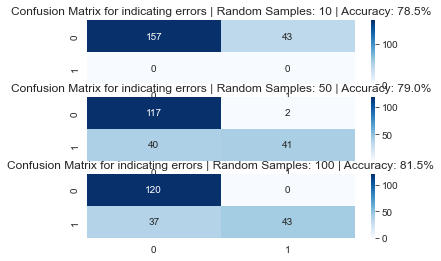

In [7]:
# select random samples and evaluate errors and CM and Accuracy
PlotIndex = 1

# n for -N-ot addicted
# a for -A-ddicted

for i in [10,50,100]:
    n_count = 0
    while n_count < 1 :
        # select random
        train_data = train_data.sample(frac=1).reset_index(drop=True)
        train_data_ = train_data.sample(i)

        #seperate each class
        not_addicted_sample = train_data_.loc[train_data['addicted'] == 0].drop('addicted', axis=1)
        addicted_sample = train_data_.loc[train_data['addicted'] == 1].drop('addicted', axis=1)
        
        n_count = not_addicted_sample.shape[0]

    # prior prob
    P0_ = not_addicted_sample.shape[0]/train_data_.shape[0]    
    P1_ = addicted_sample.shape[0]/train_data_.shape[0]
    
    # estimate parameters
    n_mean = np.array(not_addicted_sample.mean())
    n_cov = np.array(not_addicted_sample.cov())

    a_mean = np.array(addicted_sample.mean())
    a_cov = np.array(addicted_sample.cov())
    
    #evaluate the estimated parameter
    Evaluate(test_data,a_mean,a_cov,n_mean,n_cov,i,P0_,P1_)
plt.show()